In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
import cv2
import csv
import random
from matplotlib import image as mpimg
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.models import Sequential, load_model
from keras.applications.vgg19 import VGG19
from keras.layers import BatchNormalization, Dense, Flatten, Dropout
from time import time

In [2]:
df = pd.read_csv('classes.csv')
classes = df.to_numpy()

data_dir = os.getcwd()
train_path = data_dir + '/Train'
np.random.seed(42)
TOTAL_CLASSES = len(classes)

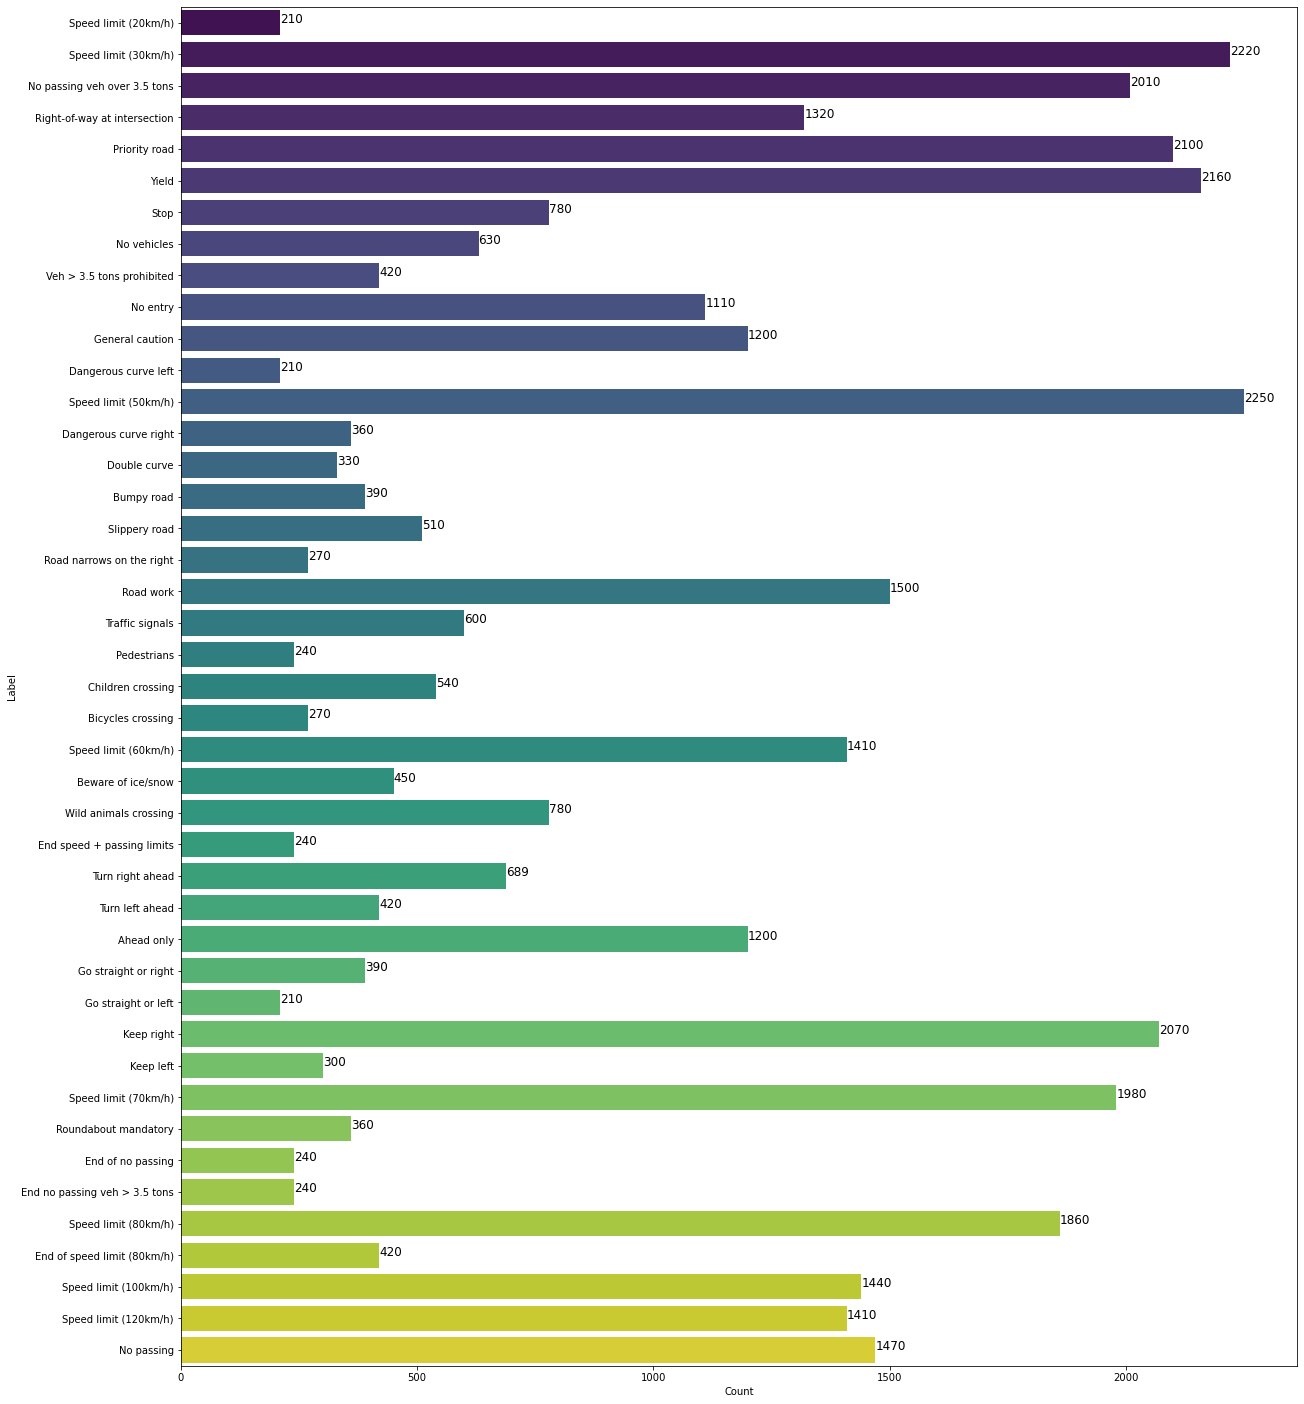

In [3]:
total_images = []
clabels = []

for i in os.listdir(train_path):
    tf = os.listdir(train_path + '/' + i)
    clabels.append(classes[int(i)][1])
    total_images.append(len(tf)) 

# data Visualizing of train images
plt.figure(figsize = (20, 25))
plt.ylabel('Label')
plt.xlabel('Count')
sns.barplot(y = clabels, x = total_images, palette = 'viridis')
sns.set_context('notebook')  
for i, val in enumerate(total_images):
    plt.text(val, i, str(val))
plt.show()

In [4]:
# preprocessing and mix of dataset
def preprocess(image, out_side):
    h, w = image.shape[:2]
    scale = out_side / max(h, w)
    dx = (out_side - scale * w) / 2
    dy = (out_side - scale * h) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mix(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(42)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mix(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mix(images, labels)

In [5]:
start = time()

train_images, train_labels = load_train(data_dir + "/", 32)
test_images, test_labels = load_test(data_dir + "/", 32)
shape = train_images[0].shape
print(shape)

# images data normalizing
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

# onehot encoding the labels 
train_labels = to_categorical(train_labels, TOTAL_CLASSES)
test_labels = to_categorical(test_labels, TOTAL_CLASSES)

print('Loading: ', time() - start)

(32, 32, 3)
Loading:  62.314016819000244


In [6]:
# dataset split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)

print("X_train.shape - ", X_train.shape)
print("X_valid.shape - ", X_val.shape)
print("y_train.shape - ", y_train.shape)
print("y_valid.shape - ", y_val.shape)

X_train.shape -  (31367, 32, 32, 3)
X_valid.shape -  (7842, 32, 32, 3)
y_train.shape -  (31367, 43)
y_valid.shape -  (7842, 43)


In [7]:
# image augmentation for better performance
train_image_aug = ImageDataGenerator(
                            rotation_range=10,
                            zoom_range=0.15,
                            horizontal_flip=False,
                            vertical_flip=False,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.15,
                            fill_mode="nearest")

# applying data augmentation to features
BATCH_SIZE= 128
train_gen = train_image_aug.flow(X_train, y_train, batch_size= BATCH_SIZE)

In [8]:
# creating model with VGG19 base (transfer learning)
vgg_conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(32,32,3)) 
vgg_model = Sequential()
vgg_model.add(vgg_conv_base)
vgg_model.add(BatchNormalization())
vgg_model.add(Flatten())
vgg_model.add(Dense(1024, activation='relu'))
vgg_model.add(Dropout(rate=0.5))
vgg_model.add(Dense(TOTAL_CLASSES, activation='softmax'))

In [9]:
LR = 0.0001 # learning rate
EPOCHS = 10
opt = Adam(lr=LR)

# Compiling the model
vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\USER\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
# Model summary
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 43)                44075     
                                                        

In [11]:
# train model
history = vgg_model.fit(train_gen, epochs=EPOCHS, validation_data=(X_val, y_val), shuffle= True)

# save model
vgg_model.save("trafficsignrecognition_model.h5")

Epoch 1/10
246/246 [==============================] - 983s 4s/step - loss: 1.4775 - accuracy: 0.5842 - val_loss: 0.8017 - val_accuracy: 0.9031
Epoch 2/10
246/246 [==============================] - 1012s 4s/step - loss: 0.2260 - accuracy: 0.9365 - val_loss: 0.0722 - val_accuracy: 0.9799
Epoch 3/10
246/246 [==============================] - 998s 4s/step - loss: 0.0853 - accuracy: 0.9754 - val_loss: 0.0677 - val_accuracy: 0.9784
Epoch 4/10
246/246 [==============================] - 1061s 4s/step - loss: 0.0606 - accuracy: 0.9819 - val_loss: 0.0506 - val_accuracy: 0.9836
Epoch 5/10
246/246 [==============================] - 1068s 4s/step - loss: 0.0439 - accuracy: 0.9869 - val_loss: 0.0227 - val_accuracy: 0.9938
Epoch 6/10
246/246 [==============================] - 966s 4s/step - loss: 0.0365 - accuracy: 0.9893 - val_loss: 0.0251 - val_accuracy: 0.9930
Epoch 7/10
246/246 [==============================] - 1020s 4s/step - loss: 0.0311 - accuracy: 0.9906 - val_loss: 0.0495 - val_accuracy: 0.

In [12]:
# load the model we saved
vgg_model = load_model('trafficsignrecognition_model.h5')

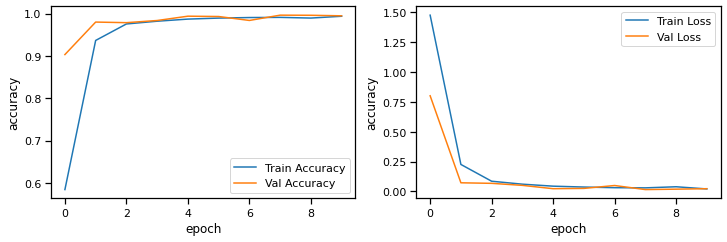

In [13]:
# plotting the history 
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [14]:
# Model evaluation
test_loss, test_acc = vgg_model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

32/32 [==============================] - 3s 87ms/step - loss: 0.2338 - accuracy: 0.9550
Test accuracy: 0.9549999833106995
Test loss: 0.23384782671928406


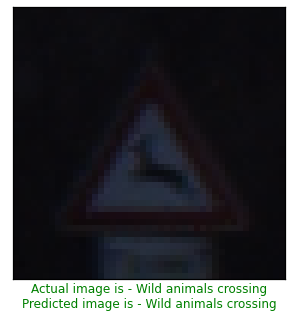

In [15]:
img_data = []
test_csv = pd.read_csv('Test.csv')
image_path = test_csv["Path"].values
image_id = test_csv["ClassId"].values

# random test image generating along with it's id
random_image = random.choice(image_path)
random_image_id = image_id[np.where(image_path == random_image)[0][0]]

image = cv2.imread(data_dir + '/' + random_image)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (5, 5))
plt.imshow(rgb_image)

image_fa = Image.fromarray(image, 'RGB')
image_resize = image_fa.resize((32, 32))
img_data.append(np.array(image_resize))
X_test = np.array(img_data)
X_test = X_test/255

predict_x = vgg_model.predict(X_test) 
pred = np.argmax(predict_x, axis = 1)
if random_image_id != pred[0]:
    plt.xlabel('Actual image is - ' + classes[random_image_id][1] + '\n'
              'Predicted image is - ' + classes[pred[0]][1], color = 'red')
else:
    plt.xlabel('Actual image is - ' + classes[random_image_id][1] + '\n'
              'Predicted image is - ' + classes[pred[0]][1], color = 'green')
plt.xticks([])
plt.yticks([])    
plt.show()
